In [1]:


import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy import sparse
from datetime import datetime
from scipy.linalg import solve
from scipy.optimize import minimize
from scipy.sparse.linalg import spsolve
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression



In [13]:
test = pd.read_csv('../data/testing/sq_scores.csv')
test['location'] = test['location'].map({'home':1, 'away':-1, 'neutral':0})
test

,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score
0,19799180318961,2024,ncaam,2024-03-17,0,UAB,Temple,85,69,82.8,72.4,82.4,72.0
1,19799052919811,2024,ncaam,2024-03-17,0,VCU,Duquesne,51,57,60.0,73.1,59.5,72.9
2,19799009306251,2024,ncaam,2024-03-17,0,Florida,Auburn,67,86,82.7,80.1,82.1,79.8
3,19799020521531,2024,ncaam,2024-03-17,0,Yale,Brown,62,61,67.8,61.1,67.5,61.0
4,19799020521531,2024,ncaam,2024-03-17,0,Brown,Yale,61,62,61.1,67.8,61.0,67.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107761,16388128618431,2015,ncaam,2014-11-14,-1,North Dakota St.,Texas,50,85,70.1,86.7,71.4,84.9
107762,16388011519611,2015,ncaam,2014-11-14,-1,Ball St.,Utah,72,90,64.2,82.2,67.3,85.3
107763,16388032906671,2015,ncaam,2014-11-14,1,Furman,Charleston,40,75,59.5,66.2,61.9,63.4
107764,16388106413601,2015,ncaam,2014-11-14,1,Ohio St.,UMass Lowell,92,55,79.3,50.5,77.5,53.8


In [23]:
class Optimizer:
    def __init__(self):
        pass

    def optimize(self):
        raise NotImplementedError("Subclasses must implement the optimize method.")


In [62]:


class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='sore', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())
        self.protags = sorted(self.protags)
        self.antags = sorted(self.antags)

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X


    def run_time_opt_scipy(self, init_points=10, n_iter=30, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_bayes_objective(offense_halflife, defense_halflife, meta_halflife, l2):
            # offense_halflife, defense_halflife, meta_halflife_bounds, l2 = params
            correlations = []
            # l2 = 1e-8
            
            offense_decay = np.exp(-np.log(2)/offense_halflife)
            defense_decay = np.exp(-np.log(2)/defense_halflife)
            meta_decay = np.exp(-np.log(2)/meta_halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Offense decay
                dwo = offense_decay ** days_ago
                
                # Defense decay
                dwd = defense_decay ** days_ago
                
                # Meta decay
                dwm = meta_decay ** days_ago

                dwo = dwo / np.sum(dwo)
                dwd = dwd / np.sum(dwd)
                dwm = dwm / np.sum(dwm)
                
                # Create separate weight matrices for offense and defense
                Wo = sparse.diags(dwo)
                Wd = sparse.diags(dwd)
                Wm = sparse.diags(dwm)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Split X_train into offense and defense parts
                X_train_offense = X_train[:, :self.num_protags]
                X_train_defense = X_train[:, self.num_protags:-1*len(self.meta_cols)]
                X_train_meta = X_train[:, -1*len(self.meta_cols):]

                # Apply the weight matrices to the corresponding parts of X_train
                X_train_weighted = sparse.hstack([Wo @ X_train_offense, Wd @ X_train_defense, Wm @ X_train_meta])

                # Quadratic term
                q = (X_train_weighted.T @ X_train_weighted).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train_weighted.T @ y_train

                if np.isnan(f).any():
                    print("Shit, something wrong")
                    return -1000

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings
                
                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                ratings_df = pd.DataFrame({
                    'off_rating': b[:self.num_protags],
                    'def_rating': b[self.num_protags:-1*len(self.meta_cols)]
                }, index=self.protags)
                print(ratings_df)
                test_data = test_data.join(ratings_df, on=self.protag_col)

                # Calculate the predicted scores
                linear_model = LinearRegression()
                linear_model.fit(test_data[['off_rating', 'def_rating', 'location']], test_data[self.stat_col])
                test_data['pred_score'] = linear_model.predict(test_data[['off_rating', 'def_rating', 'location']])
                test_data['mse'] = (test_data[self.stat_col] - test_data['pred_score']) ** 2
                mse = test_data['mse'].mean()

            return -mse  
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        pbounds = {'offense_halflife': offense_halflife_bounds, 'defense_halflife': defense_halflife_bounds, 'meta_halflife':meta_halflife_bounds, 'l2': l2_bounds}
        print(pbounds)
        # Initialize the Bayesian Optimization object
        optimizer = BayesianOptimization(f=time_bayes_objective, pbounds=pbounds, random_state=17)

        # Perform the optimization
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Get the best parameters and correlation
        best_params = optimizer.max['params']
        best_off_halflife = best_params['offense_halflife']
        best_def_halflife = best_params['defense_halflife']
        best_meta_halflife = best_params['meta_halflife']
        best_l2 = best_params['l2']
        best_correlation = -optimizer.max['target']

        return best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        optimal_off_halflifes = []
        optimal_def_halflifes = []
        optimal_meta_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation = self.run_time_opt_scipy(13, 32, num_test_dates, num_future_days, max_lookback, offense_halflife_bounds, defense_halflife_bounds, meta_halflife_bounds, l2_bounds)
            optimal_off_halflifes.append(best_off_halflife)
            optimal_def_halflifes.append(best_def_halflife)
            optimal_meta_halflifes.append(best_meta_halflife)
            optimal_l2s.append(best_l2)
            best_correlations.append(best_correlation)
        return optimal_off_halflifes, optimal_def_halflifes, optimal_meta_halflifes, optimal_l2s, best_correlations

    def get_ratings_for_dates(self, dates, offense_halflife, defense_halflife, meta_halflife, l2, max_lookback=365*2):
        X = self.initialize_X()
        num_dates = len(dates)

        offense_decay = np.exp(-np.log(2)/offense_halflife)
        defense_decay = np.exp(-np.log(2)/defense_halflife)
        meta_decay = np.exp(-np.log(2)/meta_halflife)

        print(offense_decay, defense_decay, meta_decay)

        ratings = []
        for i, date in enumerate(dates):
            # Filter data before the given date
            train_data = self.data[(self.data['date'] >= date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < date)].copy()

            print("len(train_data)",len(train_data))
            if len(train_data) < 50:
                continue

            # Calculate days_ago for each game
            days_ago = (date - train_data['date']).dt.days.values

            # Offense decay
            dwo = offense_decay ** days_ago

            # Defense decay
            dwd = defense_decay ** days_ago

            # Meta decay
            dwm = meta_decay ** days_ago

            # Scale the weights while preserving their relative proportions
            scale_factor = len(train_data) / (np.sum(dwo) + np.sum(dwd) + np.sum(dwm))
            dwo_scaled = dwo * scale_factor
            dwd_scaled = dwd * scale_factor
            dwm_scaled = dwm * scale_factor

            # Solve the weighted least squares
            idx = train_data.index
            X_train = X[idx]
            y_train = self.data.loc[idx, self.stat_col].values

            # Create separate weight matrices for offense, defense, and meta
            Wo = sparse.diags(dwo_scaled)
            Wd = sparse.diags(dwd_scaled)
            Wm = sparse.diags(dwm_scaled)

            # Apply the weight matrices to the corresponding parts of X_train
            X_train_offense = X_train[:, :self.num_protags]
            X_train_defense = X_train[:, self.num_protags:-1*len(self.meta_cols)]
            X_train_meta = X_train[:, -1*len(self.meta_cols):]

            X_weighted = sparse.hstack([Wo @ X_train_offense, Wd @ X_train_defense, Wm @ X_train_meta])
            y_weighted = y_train

            # Quadratic term
            q = (X_weighted.T @ X_weighted).toarray()
            q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

            # Linear term
            f = X_weighted.T @ y_weighted

            # Solution
            b = solve(q, f, assume_a='pos')

            # Store ratings for the given date
            daily_ratings = pd.DataFrame({
                'protag': self.protags,
                'offense_rating': b[:self.num_protags],
                'defense_rating': b[self.num_protags:-1*len(self.meta_cols)]
            })
            daily_ratings['date'] = date
            ratings.append(daily_ratings)

        return pd.concat(ratings)

MO = MasseyOptimizer('time', stat_col='team_score')
MO.load_data(test)
# off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs = MO.run_full_time_opt(num_samples=10, num_test_dates=10, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(60, 300), defense_halflife_bounds=(150,650), meta_halflife_bounds=(150,650), l2_bounds=(1e-8, 1))

# ratings = MO.get_ratings_for_dates([d for d in postseason_start.values()]+[pd.to_datetime(f'04-15-{season}') for season in list(range(2017,2024))], 105, 400, 400, 0.22, max_lookback=365*2.5)


In [63]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(test[['team_score', 'opp_score']])
test[['team_score', 'opp_score']] = scaler.transform(test[['team_score', 'opp_score']])
test



,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score
0,19799180318961,2024,ncaam,2024-03-17,0,UAB,Temple,1.128098,-0.174414,82.8,72.4,82.4,72.0
1,19799052919811,2024,ncaam,2024-03-17,0,VCU,Duquesne,-1.639739,-1.151298,60.0,73.1,59.5,72.9
2,19799009306251,2024,ncaam,2024-03-17,0,Florida,Auburn,-0.337228,1.209505,82.7,80.1,82.1,79.8
3,19799020521531,2024,ncaam,2024-03-17,0,Yale,Brown,-0.744263,-0.825670,67.8,61.1,67.5,61.0
4,19799020521531,2024,ncaam,2024-03-17,0,Brown,Yale,-0.825670,-0.744263,61.1,67.8,61.0,67.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107761,16388128618431,2015,ncaam,2014-11-14,-1,North Dakota St.,Texas,-1.721146,1.128098,70.1,86.7,71.4,84.9
107762,16388011519611,2015,ncaam,2014-11-14,-1,Ball St.,Utah,0.069807,1.535132,64.2,82.2,67.3,85.3
107763,16388032906671,2015,ncaam,2014-11-14,1,Furman,Charleston,-2.535216,0.314028,59.5,66.2,61.9,63.4
107764,16388106413601,2015,ncaam,2014-11-14,1,Ohio St.,UMass Lowell,1.697946,-1.314112,79.3,50.5,77.5,53.8


In [64]:
ratings = MO.get_ratings_for_dates([pd.to_datetime('03-01-2024')], 105, 400, 400, 0.22, max_lookback=365*2.5)
ratings

0.9934203396652016 0.9982686325973925 0.9982686325973925
len(train_data) 32238


,protag,offense_rating,defense_rating,date
0,Massachusetts,0.619581,0.016904,2024-03-01
1,Missouri St.,0.154572,0.162980,2024-03-01
2,UNLV,0.284441,-0.589488,2024-03-01
3,Maryland Eastern Shore,-0.939593,-0.342561,2024-03-01
4,DePaul,-0.490596,0.109232,2024-03-01
...,...,...,...,...
361,Tarleton St.,0.160205,-0.298284,2024-03-01
362,Queens of Charlotte,0.623158,0.937891,2024-03-01
363,St. Thomas,-0.164290,-0.207513,2024-03-01
364,Life Pacific,-0.008817,0.304764,2024-03-01


In [65]:
ratings.sort_values(by=['offense_rating'], ascending=False)

,protag,offense_rating,defense_rating,date
80,Alabama,2.257662,-0.828481,2024-03-01
86,Arizona,1.967885,-0.249569,2024-03-01
100,Kentucky,1.716233,-0.477531,2024-03-01
102,Illinois,1.518596,0.306442,2024-03-01
85,Purdue,1.433389,0.345745,2024-03-01
...,...,...,...,...
3,Maryland Eastern Shore,-0.939593,-0.342561,2024-03-01
18,Sacramento St.,-1.024833,-0.090169,2024-03-01
21,Army,-1.037791,-0.295030,2024-03-01
19,Coppin St.,-1.091785,-0.339678,2024-03-01


In [75]:
test['categorical'] = pd.qcut(test['team_sq_score'], 5, labels=False)
test[['very_low','low','medium','high','very_high']] = pd.get_dummies(test['categorical'])

In [76]:
test.loc[(test['season']==2024)&(test['team']=='Alabama')]['categorical'].mean()

3.65625

In [89]:
from scipy.special import softmax

class MasseyMultiClassOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_cols='team_sq_score', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_cols = stat_cols
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, init_points=10, n_iter=30, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_bayes_objective(offense_halflife, defense_halflife, meta_halflife, l2):
            # offense_halflife, defense_halflife, meta_halflife_bounds, l2 = params
            correlations = []
            # l2 = 1e-8
            
            offense_decay = np.exp(-np.log(2)/offense_halflife)
            defense_decay = np.exp(-np.log(2)/defense_halflife)
            meta_decay = np.exp(-np.log(2)/meta_halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Offense decay
                dwo = offense_decay ** days_ago
                dwo = dwo / np.sum(dwo)
                # Defense decay
                dwd = defense_decay ** days_ago
                dwd = dwd / np.sum(dwd)
                # Meta decay
                dwm = meta_decay ** days_ago
                dwm = dwm / np.sum(dwm)

                # Create separate weight matrices for offense and defense
                Wo = sparse.diags(dwo)
                Wd = sparse.diags(dwd)
                Wm = sparse.diags(dwm)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_cols].values

                # Split X_train into offense and defense parts
                X_train_offense = X_train[:, :self.num_protags]
                X_train_defense = X_train[:, self.num_protags:-1*len(self.meta_cols)]
                X_train_meta = X_train[:, -1*len(self.meta_cols):]

                # Apply the weight matrices to the corresponding parts of X_train
                X_train_weighted = sparse.hstack([Wo @ X_train_offense, Wd @ X_train_defense, Wm @ X_train_meta])

                # Quadratic term
                q = (X_train_weighted.T @ X_train_weighted).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train_weighted.T @ y_train

                if np.isnan(f).any():
                    print("Shit, something wrong")
                    return -1000

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings
                
                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_cols].values

                ratings_df = pd.DataFrame({
                    'off_rating': b[:self.num_protags],
                    'def_rating': b[self.num_protags:-1*len(self.meta_cols)]
                }, index=self.protags)
                print(ratings_df)
                test_data = test_data.join(ratings_df, on=self.protag_col)

                # Calculate the predicted scores
                linear_model = LinearRegression()
                linear_model.fit(test_data[['off_rating', 'def_rating', 'location']], test_data[self.stat_cols])
                test_data['pred_score'] = linear_model.predict(test_data[['off_rating', 'def_rating', 'location']])
                test_data['mse'] = (test_data[self.stat_cols] - test_data['pred_score']) ** 2
                mse = test_data['mse'].mean()

            return -mse  
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        pbounds = {'offense_halflife': offense_halflife_bounds, 'defense_halflife': defense_halflife_bounds, 'meta_halflife':meta_halflife_bounds, 'l2': l2_bounds}
        print(pbounds)
        # Initialize the Bayesian Optimization object
        optimizer = BayesianOptimization(f=time_bayes_objective, pbounds=pbounds, random_state=17)

        # Perform the optimization
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Get the best parameters and correlation
        best_params = optimizer.max['params']
        best_off_halflife = best_params['offense_halflife']
        best_def_halflife = best_params['defense_halflife']
        best_meta_halflife = best_params['meta_halflife']
        best_l2 = best_params['l2']
        best_correlation = -optimizer.max['target']

        return best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        optimal_off_halflifes = []
        optimal_def_halflifes = []
        optimal_meta_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            best_off_halflife, best_def_halflife, best_meta_halflife, best_l2, best_correlation = self.run_time_opt_scipy(13, 32, num_test_dates, num_future_days, max_lookback, offense_halflife_bounds, defense_halflife_bounds, meta_halflife_bounds, l2_bounds)
            optimal_off_halflifes.append(best_off_halflife)
            optimal_def_halflifes.append(best_def_halflife)
            optimal_meta_halflifes.append(best_meta_halflife)
            optimal_l2s.append(best_l2)
            best_correlations.append(best_correlation)
        return optimal_off_halflifes, optimal_def_halflifes, optimal_meta_halflifes, optimal_l2s, best_correlations

    def get_ratings_for_dates(self, dates, offense_halflife, defense_halflife, meta_halflife, l2, max_lookback=365*2):
        X = self.initialize_X()
        num_dates = len(dates)

        offense_decay = np.exp(-np.log(2)/offense_halflife)
        defense_decay = np.exp(-np.log(2)/defense_halflife)
        meta_decay = np.exp(-np.log(2)/meta_halflife)

        print(offense_decay, defense_decay, meta_decay)

        ratings = []
        for i, date in enumerate(dates):
            # Filter data before the given date
            train_data = self.data[(self.data['date'] >= date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < date)].copy()

            print("len(train_data)",len(train_data))
            if len(train_data) < 50:
                continue

            # Calculate days_ago for each game
            days_ago = (date - train_data['date']).dt.days.values

            # Offense decay
            dwo = offense_decay ** days_ago

            # Defense decay
            dwd = defense_decay ** days_ago

            # Meta decay
            dwm = meta_decay ** days_ago

            # Scale the weights while preserving their relative proportions
            scale_factor = len(train_data) / (np.sum(dwo) + np.sum(dwd) + np.sum(dwm))
            dwo_scaled = dwo * scale_factor
            dwd_scaled = dwd * scale_factor
            dwm_scaled = dwm * scale_factor

            # Solve the weighted least squares
            idx = train_data.index
            X_train = X[idx]
            y_train = self.data.loc[idx, self.stat_cols].values

            # Create separate weight matrices for offense, defense, and meta
            Wo = sparse.diags(dwo_scaled)
            Wd = sparse.diags(dwd_scaled)
            Wm = sparse.diags(dwm_scaled)

            # Apply the weight matrices to the corresponding parts of X_train
            X_train_offense = X_train[:, :self.num_protags]
            X_train_defense = X_train[:, self.num_protags:-1*len(self.meta_cols)]
            X_train_meta = X_train[:, -1*len(self.meta_cols):]

            X_weighted = sparse.hstack([Wo @ X_train_offense, Wd @ X_train_defense, Wm @ X_train_meta])
            y_weighted = y_train

            # Solve the weighted least squares problem for all stat columns simultaneously
            # Quadratic term
            q = (X_weighted.T @ X_weighted).toarray()
            q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

            # Linear term
            f = X_weighted.T @ y_train

            # Solution
            b = solve(q, f, assume_a='pos')

            # Convert the raw outputs to probabilities using softmax
            probabilities = softmax(b, axis=1)

            # Store ratings for the given date
            stat_cols = self.stat_cols  # Assuming stat_cols contains the column names for each stat
            num_stats = len(stat_cols)
            daily_ratings = pd.DataFrame({
                'protag': self.protags,
                **{stat_col: probabilities[:self.num_protags, i] for i, stat_col in enumerate(stat_cols)}
            })
            daily_ratings['date'] = date
            ratings.append(daily_ratings)

            # # Store ratings for the given date
            # daily_ratings = pd.DataFrame({
            #     'protag': self.protags,
            #     'offense_rating': b[:self.num_protags],
            #     'defense_rating': b[self.num_protags:-1*len(self.meta_cols)]
            # })
            # daily_ratings['date'] = date
            # ratings.append(daily_ratings)

        return pd.concat(ratings)

MO = MasseyMultiClassOptimizer('time', stat_cols=['very_low','low','medium','high','very_high'])
MO.load_data(test)
# off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs = MO.run_full_time_opt(num_samples=10, num_test_dates=10, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(60, 300), defense_halflife_bounds=(150,650), meta_halflife_bounds=(150,650), l2_bounds=(1e-8, 1))

# ratings = MO.get_ratings_for_dates([d for d in postseason_start.values()]+[pd.to_datetime(f'04-15-{season}') for season in list(range(2017,2024))], 105, 400, 400, 0.22, max_lookback=365*2.5)



In [90]:

ratings = MO.get_ratings_for_dates([pd.to_datetime('03-17-2024')], 105, 400, 400, 0.22, max_lookback=365*2.5)


0.9934203396652016 0.9982686325973925 0.9982686325973925
len(train_data) 33600


In [92]:
ratings.sort_values(by=['very_high'], ascending=False).head(50)

,protag,very_low,low,medium,high,very_high,date
80,Alabama,0.125631,0.132057,0.154233,0.169113,0.418966,2024-03-17
147,Wright St.,0.134577,0.138730,0.143277,0.165208,0.418209,2024-03-17
136,Florida,0.131523,0.153699,0.147320,0.178518,0.388939,2024-03-17
86,Arizona,0.124039,0.156005,0.173425,0.210537,0.335994,2024-03-17
71,Creighton,0.139848,0.152948,0.192260,0.191203,0.323740,2024-03-17
102,Illinois,0.132816,0.154799,0.184688,0.208023,0.319674,2024-03-17
109,BYU,0.122654,0.166027,0.192917,0.206710,0.311692,2024-03-17
49,Gonzaga,0.152465,0.147235,0.174436,0.221486,0.304378,2024-03-17
124,High Point,0.143209,0.168026,0.170318,0.216021,0.302426,2024-03-17
187,New Mexico,0.123501,0.142936,0.167069,0.267011,0.299484,2024-03-17


In [ ]:
'


np.median(off_halflifes), np.median(def_halflifes), np.mean(optimal_meta_halflife), np.median(l2s), np.median(corrs)

(85.60637103913905,
 457.4346128489125,
 408.9020340622961,
 0.22645771820084087,
 128.0377188230237)

[94.91665611236816,
 72.31293415459723,
 66.87494683445117,
 278.6561237805382,
 275.4060520742849,
 64.74066550346397,
 278.6561237805382,
 100.09582697605816,
 73.93244044651932,
 76.29608596590992]

In [ ]:
MO = MasseyOptimizer('time')
MO.load_data(test)
off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs = MO.run_full_time_opt(num_samples=25, num_test_dates=30, num_future_days=60, max_lookback=365*2, offense_halflife_bounds=(50, 800), defense_halflife_bounds=(50,800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1))


In [ ]:
off_halflifes, def_halflifes, optimal_meta_halflife, l2s, corrs

([83.56163381879595,
  225.9960560835481,
  109.29241760705779,
  332.7152067347931,
  58.932677911659724,
  386.17029871384835,
  134.48919343675718,
  54.490296092083874,
  305.10716395246567,
  93.96502586112683,
  73.16837905960467,
  62.1613911865939,
  60.03843971998231,
  50.04917964866829,
  65.05537330470503,
  85.87179415115466,
  81.2858592279815,
  70.14808789041535,
  55.518314512135,
  71.37270654653875,
  73.88074820881872,
  52.20529146693021,
  115.99530486877656,
  91.43101266186783,
  50.30143902992544],
 [376.46279571533523,
  588.686811841095,
  610.2861327062105,
  681.5327759386106,
  271.2995760229007,
  740.0955428537465,
  389.2450888402862,
  465.5865228298951,
  645.4034287839422,
  615.6727252195888,
  274.6761276234264,
  514.9770761008486,
  320.64377708768836,
  76.59024398924498,
  387.8379094445319,
  632.1082826745063,
  785.36916650189,
  337.3543379257496,
  255.79761258969845,
  284.04912851297354,
  533.7195464452547,
  657.966446377666,
  404.470

In [ ]:
np.median(off_halflifes), np.median(def_halflifes), np.mean(optimal_meta_halflife), np.median(l2s), np.median(corrs)

(73.6935282514663,
 541.5642044379127,
 450.7628681345297,
 0.2996442825886254,
 124.40339695920282)

In [ ]:
np.std(off_halflifes), np.std(def_halflifes), np.std(optimal_meta_halflife), np.std(l2s), np.std(corrs)

(92.10691318499515,
 176.21541259172625,
 203.1543083267181,
 0.1613359224359658,
 6.280611567208136)

In [ ]:

class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='team_sq_score', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, init_points=10, n_iter=30, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_bayes_objective(halflife, meta_halflife, l2):
            # offense_halflife, defense_halflife, meta_halflife_bounds, l2 = params
            correlations = []
            # l2 = 1e-8
            
            decay = np.exp(-np.log(2)/halflife)
            meta_decay = np.exp(-np.log(2)/meta_halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Offense decay
                dw = decay ** days_ago
                dw = dw / np.sum(dw)

                # Meta decay
                dwm = meta_decay ** days_ago
                dwm = dwm / np.sum(dwm)

                # Create separate weight matrices for offense and defense
                W = sparse.diags(dw)
                Wm = sparse.diags(dwm)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Split X_train into offense and defense parts
                X_train_teams = X_train[:, :-1*len(self.meta_cols)]
                X_train_meta = X_train[:, -1*len(self.meta_cols):]

                # Apply the weight matrices to the corresponding parts of X_train
                X_train_weighted = sparse.hstack([W @ X_train_teams, Wm @ X_train_meta])

                # Quadratic term
                q = (X_train_weighted.T @ X_train_weighted).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train_weighted.T @ y_train

                if np.isnan(f).any():
                    print("Shit, something wrong")
                    return -1000

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings
                
                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                ratings_df = pd.DataFrame({
                    'off_rating': b[:self.num_protags],
                    'def_rating': b[self.num_protags:-1*len(self.meta_cols)]
                }, index=self.protags)
                test_data = test_data.join(ratings_df, on=self.protag_col)

                # Calculate the predicted scores
                linear_model = LinearRegression()
                linear_model.fit(test_data[['off_rating', 'def_rating', 'location']], test_data[self.stat_col])
                test_data['pred_score'] = linear_model.predict(test_data[['off_rating', 'def_rating', 'location']])
                test_data['mse'] = (test_data[self.stat_col] - test_data['pred_score']) ** 2
                mse = test_data['mse'].mean()

            return -mse  
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        pbounds = {'halflife': halflife_bounds,'meta_halflife':meta_halflife_bounds, 'l2': l2_bounds}
        # Initialize the Bayesian Optimization object
        optimizer = BayesianOptimization(f=time_bayes_objective, pbounds=pbounds, random_state=17)

        # Perform the optimization
        optimizer.maximize(init_points=init_points, n_iter=n_iter)

        # Get the best parameters and correlation
        best_params = optimizer.max['params']
        best_halflife = best_params['halflife']
        best_meta_halflife = best_params['meta_halflife']
        best_l2 = best_params['l2']
        best_correlation = -optimizer.max['target']

        return best_halflife, best_meta_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1)):

        optimal_halflifes = []
        optimal_meta_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            best_halflife, best_meta_halflife, best_l2, best_correlation = self.run_time_opt_scipy(13, 32, num_test_dates, num_future_days, max_lookback, halflife_bounds, meta_halflife_bounds, l2_bounds)
            optimal_halflifes.append(best_halflife)
            optimal_meta_halflifes.append(best_meta_halflife)
            optimal_l2s.append(best_l2)
            best_correlations.append(best_correlation)
        return optimal_halflifes, optimal_meta_halflifes, optimal_l2s, best_correlations

MO = MasseyOptimizer('time')
MO.load_data(test)
halflifes, meta_halflife, opt_l2s, mses = MO.run_full_time_opt(num_samples=25, num_test_dates=30, num_future_days=60, max_lookback=365*2, halflife_bounds=(50, 800), meta_halflife_bounds=(100,800), l2_bounds=(1e-8, 1))



  0%|          | 0/25 [00:00<?, ?it/s]

|   iter    |  target   | halflife  |    l2     | meta_h... |
-------------------------------------------------------------
                       off_rating    def_rating
Howard               68228.857474  74670.096293
Elon                 77447.255073  64174.763818
Wright St.           85158.529748  89730.353752
Belmont              98524.010933  79213.722804
Chicago St.          69982.391311  80160.771965
...                           ...           ...
Tarleton St.             0.000000      0.000000
Queens of Charlotte      0.000000      0.000000
St. Thomas               0.000000      0.000000
Life Pacific             0.000000      0.000000
Le Moyne                 0.000000      0.000000

[366 rows x 2 columns]
                        off_rating     def_rating
Howard               445438.416998  466838.566260
Elon                 523995.890171  494815.256293
Wright St.           449998.829941  557964.206605
Belmont              632776.261918  430461.122759
Chicago St.          40770

  0%|          | 0/25 [00:10<?, ?it/s]

                        off_rating     def_rating
Howard               735239.962203  736265.477774
Elon                 613996.929962  615921.151198
Wright St.           908025.222301  718317.537347
Belmont              789536.425301  775418.029093
Chicago St.          508421.565437  669335.996389
...                            ...            ...
Tarleton St.         600789.873385  607940.515453
Queens of Charlotte  638162.055545  667305.729231
St. Thomas           620834.928055  633131.320434
Life Pacific          73294.300728  130878.351180
Le Moyne             279551.152289  321602.651434

[366 rows x 2 columns]
                        off_rating     def_rating
Howard               127305.206310  149857.748215
Elon                 173086.979466  152713.299831
Wright St.           162949.448168  183716.638046
Belmont              206894.362027  158452.959687
Chicago St.          125423.811066  153418.094451
...                            ...            ...
Tarleton St.              

KeyboardInterrupt: 

In [ ]:

np.median(halflifes), np.median(meta_halflife), np.median(opt_l2s), np.median(mses)

(74.18565260831396, 308.28830380285353, 0.3013423352607117, 88.4100941952006)

In [ ]:
(73.88074820881872,
 404.47097227847684,
 437.71088526903407,
 0.18075404766133624,
 85.96065998498014)

In [ ]:
np.std(halflifes), np.std(meta_halflife), np.std(opt_l2s), np.std(mses)

(197.37831322602327,
 146.30229854502608,
 0.30217234414775157,
 19.085673252048554)

In [22]:


class MasseyOptimizer(Optimizer):
    def __init__(self, decay_type, protag_col='team', antag_col='opponent', stat_col='sq_diff', meta_cols=['location']):
        super().__init__()
        assert(decay_type in ['time', 'games','both'])
        self.decay_type = decay_type
        self.protag_col = protag_col
        self.antag_col = antag_col
        self.stat_col = stat_col
        self.meta_cols = meta_cols

    def load_data(self, data, path=None):
        if path is not None:
            self.data = pd.read_csv(path)
        else:
            self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        # Convert date column to datetime if needed
        if isinstance(self.data['date'].iloc[0], str):
            self.data['date'] = pd.to_datetime(self.data['date'])

        # Sort data by date
        self.data = self.data.sort_values('date').reset_index(drop=True)

        # Create a team/player list
        self.protags = list(self.data[self.protag_col].unique())
        self.antags = list(self.data[self.antag_col].unique())

        self.num_protags = len(self.protags)

        self.data['protag_idx'] = self.data[self.protag_col].apply(lambda x: self.protags.index(x))
        self.data['antag_idx'] = self.data[self.antag_col].apply(lambda x: self.antags.index(x))

        assert(len(self.data)>200), "Not enough data to optimize"

    def initialize_X(self):
        X = np.zeros((len(self.data), 2*self.num_protags+len(self.meta_cols)))
        X[np.arange(len(self.data)), self.data['protag_idx']] = 1
        X[np.arange(len(self.data)), self.data['antag_idx']+self.num_protags] = 1
        for i, col in enumerate(self.meta_cols):
            X[np.arange(len(self.data)), -1] = self.data[col]
        X = sparse.csr_matrix(X)

        return X

    def run_time_opt_scipy(self, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1)):

        X = self.initialize_X()

        # Select random test dates
        unique_dates = self.data['date'].unique()
        test_dates = np.random.choice(unique_dates, size=num_test_dates, replace=False)
        num_dates = len(unique_dates)

        def time_scipy_objective(params):
            halflife, l2 = params
            correlations = []
            # l2 = 1e-8
            
            decay = np.exp(-np.log(2)/halflife)

            # empty arrays for storing offense and defense ratings each day
            massey_o_ratings = np.zeros((num_dates, self.num_protags))
            massey_d_ratings = np.zeros((num_dates, self.num_protags))

            test_o_ratings = np.zeros((num_dates, self.num_protags))
            test_d_ratings = np.zeros((num_dates, self.num_protags))

            for i, test_date in enumerate(test_dates):

                # Filter data before the test date
                train_data = self.data[(self.data['date'] >= test_date - pd.Timedelta(days=max_lookback)) & (self.data['date'] < test_date)].copy()
                test_data = self.data[(self.data['date'] >= test_date) & (self.data['date'] <= test_date + pd.Timedelta(days=num_future_days))].copy()

                if len(train_data) < 50 or len(test_data) < 50:
                    continue

                # Calculate days_ago for each game
                days_ago = (test_date - train_data['date']).dt.days.values

                # Decay weights
                dw = decay ** days_ago
                dw = dw / np.sum(dw)
                W = sparse.diags(dw)

                # Solve the weighted least squares
                idx = train_data.index
                X_train = X[idx]
                y_train = self.data.loc[idx, self.stat_col].values

                # Quadratic term
                q = (X_train.T @ W @ X_train).toarray()
                q += l2 * np.eye(q.shape[0]) * np.trace(q) / q.shape[0]

                # Linear term
                f = X_train.T @ W @ y_train

                # Solution
                b = solve(q, f, assume_a='pos')

                # Store ratings for the training date
                massey_o_ratings[i] = b[0:self.num_protags]  # First n elements are offense ratings
                massey_d_ratings[i] = b[self.num_protags:-1*len(self.meta_cols)]   # Remaining elements are defense ratings

                # Calculate ratings for the test date (without decay)
                test_idx = test_data.index
                X_test = X[test_idx]
                y_test = test_data[self.stat_col].values

                # Quadratic term for test data
                test_q = (X_test.T @ X_test).toarray()
                test_q += l2 * np.eye(test_q.shape[0]) * np.trace(test_q) / test_q.shape[0]

                # Linear term for test data
                test_f = X_test.T @ y_test

                # Solution for test data
                test_b = solve(test_q, test_f, assume_a='pos')

                test_o_ratings[i] = test_b[0:self.num_protags]
                test_d_ratings[i] = test_b[self.num_protags:-1*len(self.meta_cols)]

                # Calculate correlation
                offense_correlation = np.corrcoef(massey_o_ratings[i], test_o_ratings[i])[0, 1]
                defense_correlation = np.corrcoef(massey_d_ratings[i], test_d_ratings[i])[0, 1]
                correlations.append(offense_correlation)
                correlations.append(defense_correlation)

            avg_correlation = np.mean(correlations)
            return -avg_correlation  # Minimize the negative of the average correlation
        
        best_decay_factor = None
        best_l2 = None
        best_correlation = -1

        # Define the bounds for decay factor and L2 regularization
        bounds = [halflife_bounds, l2_bounds]

        # Perform the optimization
        result = minimize(time_scipy_objective, x0=[120, 1e-8], bounds=bounds)

        best_halflife, best_l2 = result.x
        best_correlation = -result.fun

        return best_halflife, best_l2, best_correlation

    def run_full_time_opt(self, num_samples=25, num_test_dates=20, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1)):

        optimal_halflifes = []
        optimal_l2s = []
        best_correlations = []
        for i in tqdm(range(num_samples), total=num_samples):
            halflife, l2, correlation = self.run_time_opt_scipy(num_test_dates, num_future_days, max_lookback, halflife_bounds, l2_bounds)
            optimal_halflifes.append(halflife)
            optimal_l2s.append(l2)
            best_correlations.append(correlation)
        return optimal_halflifes, optimal_l2s, best_correlations

MO = MasseyOptimizer('time','team_score')
MO.load_data(test)
halflifes, l2s, corrs = MO.run_full_time_opt(num_samples=25, num_test_dates=25, num_future_days=60, max_lookback=365*2, halflife_bounds=(10, 1000), l2_bounds=(1e-9, 1e1))


  0%|          | 0/25 [00:00<?, ?it/s]


IndexError: index 229 is out of bounds for axis 1 with size 229

In [ ]:
np.median(corrs)

0.6676111721648849

In [ ]:
np.std(corrs)

0.044042715309061384

In [ ]:
np.median(halflifes)


92.23985697579771

In [ ]:
halflifes

[105.57193833059459,
 96.3410449944243,
 86.14671780182705,
 16.42583170971897,
 91.6117921541929,
 89.7567674650214,
 119.99968000107165,
 81.28030192688627,
 93.41436027475089,
 119.9920154854931,
 119.99797979854158,
 89.30346448249918,
 92.23985697579771,
 120.00409454462151,
 89.75819238764045,
 91.15336032186006,
 96.8520044060696,
 119.99810319134951,
 92.60876654549917,
 75.87486206203891,
 79.53062624455218,
 87.87488774423323,
 97.94089883070704,
 95.77691915330247,
 79.99390742911974]

In [ ]:
np.std(halflifes)

20.609630074443366

(array([ 2.,  1.,  1.,  2.,  9., 10., 16., 13., 28., 52., 48., 61., 79.,
        75., 91., 73., 87., 76., 69., 50., 50., 27., 26., 19., 12.,  7.,
         9.,  3.,  1.,  3.]),
 array([ 45.75134609,  49.18600053,  52.62065497,  56.05530941,
         59.48996385,  62.92461829,  66.35927273,  69.79392717,
         73.22858161,  76.66323606,  80.0978905 ,  83.53254494,
         86.96719938,  90.40185382,  93.83650826,  97.2711627 ,
        100.70581714, 104.14047158, 107.57512602, 111.00978046,
        114.4444349 , 117.87908934, 121.31374378, 124.74839822,
        128.18305266, 131.6177071 , 135.05236154, 138.48701598,
        141.92167042, 145.35632486, 148.7909793 ]),
 <BarContainer object of 30 artists>)

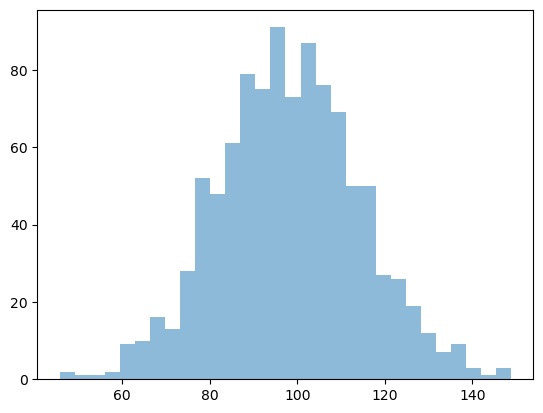

In [ ]:
import matplotlib.pyplot as plt

dist = np.random.normal(np.mean(halflifes), np.std(halflifes), 1000)
plt.hist(dist, bins=30, alpha=0.5, label='Halflife')

In [ ]:
np.median(l2s)

0.023284211858924424

In [ ]:
MO.run_time_opt_scipy()

(10, 1000) (1e-09, 10.0)
120.0 1e-08
120.00000001 1e-08
120.0 2e-08
119.99992987806037 10.0
119.99992988806036 10.0
119.99992987806037 9.99999999
119.99997662875995 3.3329426171596155
119.99997663875995 3.3329426171596155
119.99997662875995 3.3329426271596154
119.99999221968864 1.109540248475384
119.99999222968863 1.109540248475384
119.99999221968864 1.109540258475384
119.99998492739546 1.1085146783179702
119.99998493739545 1.1085146783179702
119.99998492739546 1.1085146883179702
119.99995575822275 1.1044123976883151
119.99995576822275 1.1044123976883151
119.99995575822275 1.104412407688315
119.99983908153193 1.0880032751696946
119.99983909153192 1.0880032751696946
119.99983908153193 1.0880032851696946
119.99937237476864 1.0223667850952127
119.99937238476863 1.0223667850952127
119.99937237476864 1.0223667950952127
119.99750554771548 0.7598208247972851
119.99750555771547 0.7598208247972851
119.99750554771548 0.7598208347972851
119.99210285910503 1.000000082740371e-09
119.99210286910503 

(73.47040255911598, 0.04358970749781252, 0.6879707722143393)

In [ ]:
t = pd.read_csv('test.csv')
t.sort_values(by=['test_o'], ascending=False).head(50)
t.corr()
t.sort_values(by=['massey_o'], ascending=False).head(50)

,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score,sq_diff
287,19784006508861,2024,ncaam,2024-03-02,1,Kentucky,Arkansas,111,102,92.4,87.7,NaN,NaN,4.7
627,19780088611471,2024,ncaam,2024-02-27,-1,Kentucky,Mississippi St.,91,89,78.2,76.8,NaN,NaN,1.4
952,19777001708861,2024,ncaam,2024-02-24,1,Kentucky,Alabama,117,95,85.7,83.7,NaN,NaN,2.0
1213,19774088610041,2024,ncaam,2024-02-21,-1,Kentucky,LSU,74,75,73.8,69.2,NaN,NaN,4.6
1567,19770009308861,2024,ncaam,2024-02-17,-1,Kentucky,Auburn,70,59,69.9,77.2,70.2,80.3,-7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105681,16397088611751,2015,ncaam,2014-11-23,1,Kentucky,Montana St.,86,28,104.3,52.3,102.6,59.6,52.0
105973,16395017808861,2015,ncaam,2014-11-21,1,Kentucky,Boston University,89,65,91.5,65.9,88.1,70.3,25.6
106216,16392087008861,2015,ncaam,2014-11-18,0,Kentucky,Kansas,72,40,76.5,69.6,77.3,73.1,6.9
106382,16390021508861,2015,ncaam,2014-11-16,1,Kentucky,Buffalo,71,52,82.7,50.6,83.4,56.0,32.1


In [ ]:
MO.data.loc[MO.data['team'] == 'Kentucky']

,game_id,season,league,date,location,team,opponent,team_score,opp_score,team_sq_score,opp_sq_score,initial_team_sq_score,initial_opp_sq_score,sq_diff,protag_idx,antag_idx
215,16388071608861,2015,ncaam,2014-11-14,1,Kentucky,Grand Canyon,85,45,96.6,49.3,93.3,55.1,47.3,215,215
309,16390021508861,2015,ncaam,2014-11-16,1,Kentucky,Buffalo,71,52,82.7,50.6,83.4,56.0,32.1,215,141
504,16392087008861,2015,ncaam,2014-11-18,0,Kentucky,Kansas,72,40,76.5,69.6,77.3,73.1,6.9,215,130
736,16395017808861,2015,ncaam,2014-11-21,1,Kentucky,Boston University,89,65,91.5,65.9,88.1,70.3,25.6,215,270
1018,16397088611751,2015,ncaam,2014-11-23,1,Kentucky,Montana St.,86,28,104.3,52.3,102.6,59.6,52.0,215,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105336,19770009308861,2024,ncaam,2024-02-17,-1,Kentucky,Auburn,70,59,69.9,77.2,70.2,80.3,-7.3,215,46
105585,19774088610041,2024,ncaam,2024-02-21,-1,Kentucky,LSU,74,75,73.8,69.2,NaN,NaN,4.6,215,223
105905,19777001708861,2024,ncaam,2024-02-24,1,Kentucky,Alabama,117,95,85.7,83.7,NaN,NaN,2.0,215,10
106159,19780088611471,2024,ncaam,2024-02-27,-1,Kentucky,Mississippi St.,91,89,78.2,76.8,NaN,NaN,1.4,215,198
